Imports

In [3]:
from orbit_generation_testing.reader import *
from orbit_generation_testing.processing import *

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
import tsgm

2024-04-19 12:25:06.181522: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 12:25:06.589849: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 12:25:06.589948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 12:25:06.677910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 12:25:06.858771: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 12:25:06.862582: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Data

## Imports

In [4]:
data_path = r"/workspaces/orbit-generation-testing/data/orbit_data_by_period.h5"

In [3]:
data_path = r"C:\Users\alvar\Documents\GitHub\orbit-generation-testing\data\orbit_data_by_period.h5"

In [5]:
data = load_orbit_data(data_path, dataset_path='orbit_data')
data.shape

: 

In [5]:
labels_path = r"C:\Users\alvar\Documents\GitHub\orbit-generation-testing\data\orbit_data_by_period_labels.npy"
labels = np.load(labels_path)
labels.shape

(180355,)

## Selection and Interpolation (only for testing)

In [17]:
import numpy as np
import pandas as pd

np.random.seed(42)
indices = np.random.choice(data.shape[0], 64, replace=False)

# Select the data and labels using these indices
selected_data = data[indices]
selected_labels = labels[indices]

data = selected_data
labels = selected_labels



In [ ]:
np.save('test_data.npy',data)
np.save('test_labels.npy',labels)

In [3]:
data = np.load('test_data.npy')
labels = np.load('test_labels.npy')

In [6]:
data = resample_3d_array(data=data, axis=2, target_size=500)

## Transformation

In [7]:
transposed_orbits = np.transpose(data, (0, 2, 1))

In [8]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
scaled_data.shape

(64, 500, 7)

# Generation

## Make GPU available

In [1]:
import platform
import os
import psutil
from tensorflow.python.client import device_lib

print(platform.system())
print(platform.release())

print("Number of CPUs:", os.cpu_count())
print("Total memory:", psutil.virtual_memory().total / (1024**3), "GB")

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print("Available GPUs:", get_available_gpus())

2024-04-19 14:46:40.374427: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 14:46:40.448632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 14:46:40.448751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 14:46:40.452021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 14:46:40.467508: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 14:46:40.469932: I tensorflow/core/platform/cpu_feature_guard.cc:1

Linux
5.15.146.1-microsoft-standard-WSL2
Number of CPUs: 8
Total memory: 7.236400604248047 GB
Available GPUs: []


## Parameters

In [9]:
latent_dim = 32
feature_dim = 7
seq_len = 500 # CHECK!!!!
batch_size = 32
epochs = 2 # CHECK!!!!

## Define Architecture

In [10]:
architecture = tsgm.models.zoo["vae_conv5"](seq_len=seq_len, feat_dim=feature_dim, latent_dim=latent_dim)
encoder, decoder = architecture.encoder, architecture.decoder

## Fit

In [11]:
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(scaled_data, epochs=epochs, batch_size=batch_size)

Epoch 1/2
2/2 [==============================] - 765s 428s/step - loss: 4193.3584 - reconstruction_loss: 4157.9570 - kl_loss: 0.1305
Epoch 2/2
2/2 [==============================] - 999s 543s/step - loss: 3531.5832 - reconstruction_loss: 3834.2429 - kl_loss: 33.6926


In [ ]:
encoder.save('encoder_conv5_by_period', save_format='tf')
decoder.save('decoder_conv5_by_period', save_format='tf')

## Predict

In [13]:
x_decoded = vae.predict(scaled_data)

2/2 [==============================] - 8s 3s/step


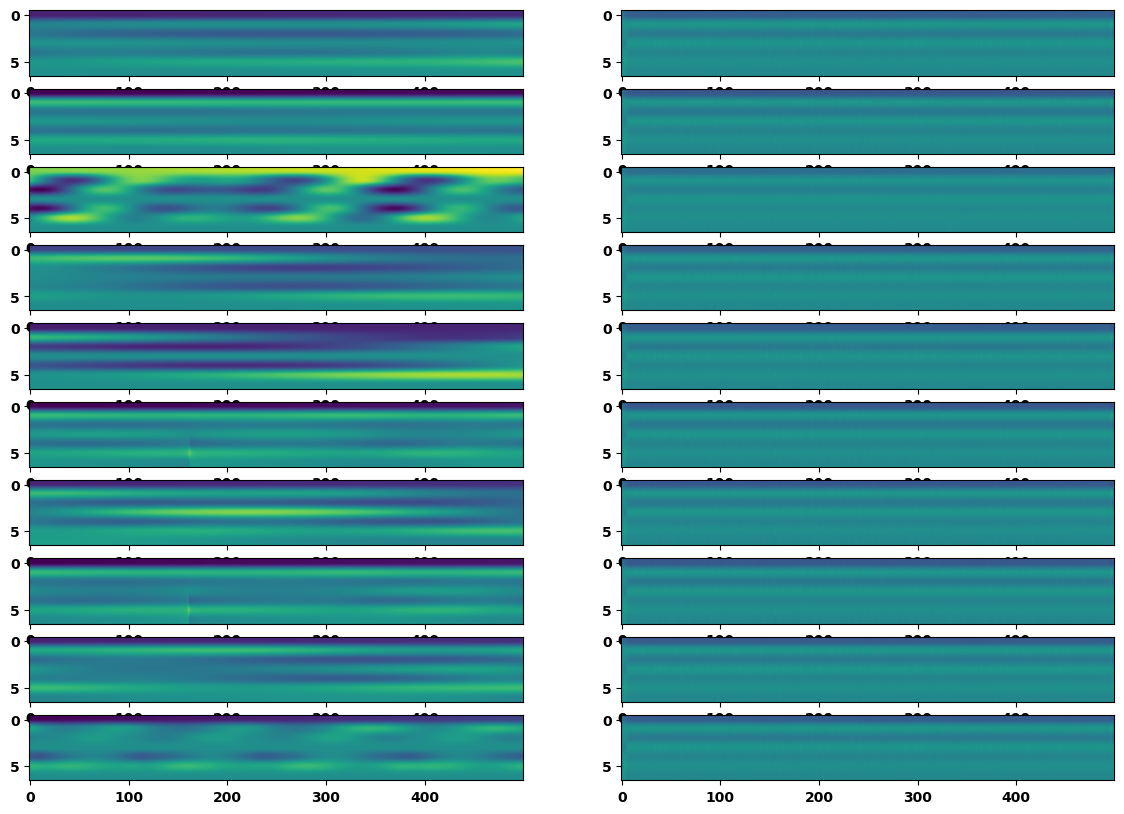

In [14]:
tsgm.utils.visualize_original_and_reconst_ts(scaled_data, x_decoded, num=10)

## Generate

In [17]:
generation = vae.generate(10)
generation.shape

TensorShape([5, 500, 7])

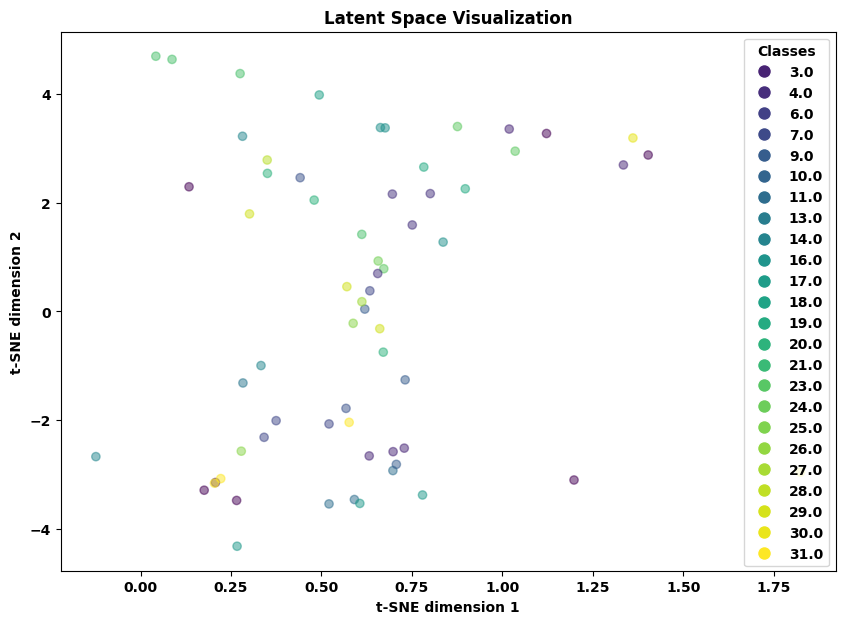

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Encode data into the latent space
latent_mean, _, _ = vae.encoder(scaled_data)
latent_representations = latent_mean.numpy()  # Convert tensor to numpy array

# Use t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(latent_representations)

# Assuming 'labels' is a NumPy array containing the class labels for each data point
# Plot the t-SNE output with colors
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c=labels, cmap='viridis')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.title('Latent Space Visualization')

# Create a legend
# Generate a legend with the unique labels
classes = np.unique(labels)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / max(classes)), markersize=10) for i in classes]
plt.legend(handles, classes, title="Classes")

plt.show()
